In [1]:
import utilities
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout , SpatialDropout2D
from tensorflow.keras.layers import AveragePooling2D, Activation
from tensorflow.keras.callbacks import History
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from  tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.regularizers import l1_l2, l1,l2
from tensorflow.keras.models import model_from_json
from sklearn.utils import class_weight
import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import pyprog
import os

def set_gpus(gpus_number="1,2"):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = gpus_number
    
SETTINGS_DIR = os.path.dirname(os.path.realpath('__file__'))

speaker_name=input("Which speaker do you want to train/test? ")
train_set_path = SETTINGS_DIR+'/images/Dysarthric/Train/'+speaker_name
test_set_path = SETTINGS_DIR+"/images/Dysarthric/Test/"+speaker_name
dnn_file_name_structure = SETTINGS_DIR +"/Models/cnn_"+speaker_name+".json"
training_dynamics_path = SETTINGS_DIR+'/Training Performance/TrainingDynamics'+speaker_name+'.csv'
dnn_file_name_weights = SETTINGS_DIR +  "/Models/cnn_weight_"+speaker_name+".h5"

batch_size=256
image_input_size=(150,150)
vocab_size = utilities.get_no_folders_in_path(test_set_path)
print ("Vocabulary Size:",vocab_size)

def model_compile(model,lr=0.001):
    model.compile(loss=losses.categorical_crossentropy,
                          optimizer=optimizers.Adam(lr),
                          metrics=['accuracy'])
    
def get_model(hp):
    droprates=hp.Float('droprate', 0.2, 0.75, sampling='linear')
    learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')
    first_train=hp.Choice('first_train', values=['2','3','4'])
    model = FreezeLayers(droprates, load_model(learning_rate=learning_rate), top_unfrozen_layer_name="separable_conv2d_"+ first_train)

    return model

def predict_an_image(image_path, model):
    
    from tensorflow.keras.preprocessing import image

    test_image = image.load_img(image_path, target_size = image_input_size)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0) 

    y_pred = model.predict_classes(test_image,batch_size)[0]
    classes =training_set.class_indices
    for key, value in classes.items():
        if value==y_pred:
            break       

    pred_key=utilities.dictionary .index [ utilities.dictionary  ['FILE NAME'] == key ] 
    predicted_word=utilities.dictionary .iloc[pred_key[0],0]
    # Get true label
    true_key=true_key=utilities.file_to_index(image_path)
    true_word = utilities.dictionary .iloc[true_key,0]
    #print("Predicted:",predicted_word,", True:",true_word)
    return predicted_word, true_word

def read_epoch():
    if os.path.exists(training_dynamics_path):
        
        # First check the csv file has headres and add then if missing
        try:
            training_dynamics=pd.read_csv(training_dynamics_path)
            training_dynamics["Epoch"][len(training_dynamics)-1]
        except:
            df = pd.read_csv(training_dynamics_path, header=None, index_col=None)
            df.columns = columns=["","Epoch","TrainingLoss", "TrainingAccuracy","ValidationLoss","ValidationAccuracy"]
            df.to_csv(training_dynamics_path, index=False)
        training_dynamics=pd.read_csv(training_dynamics_path)               
        return training_dynamics["Epoch"][len(training_dynamics)-1]
        
    else:
        return 0

def load_model(learning_rate=0.001):
    # Loading the CNN
    json_file = open(dnn_file_name_structure, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights(dnn_file_name_weights)
    print(learning_rate)
    model_compile(model,learning_rate)
    return model

def save_model(model,is_max_val_inclluded=False,max_val=None, ep=None):
    # Save/overwrite the model
    if (is_max_val_inclluded):
        json_file_name = SETTINGS_DIR+"/Models/cnn_"+speaker_name+"_"+str(max_val)+"_"+str(ep)+".json"
        wights_file_name = SETTINGS_DIR+"/Models/cnn_weight_"+speaker_name+"_"+str(max_val)+"_"+str(ep)+".h5"
        # Delete previously stored models for this speaker
        for directory, s, files in os.walk(SETTINGS_DIR+"/Models/"):
            for f in files:
                if speaker_name in f:
                    file_path=directory+"/"+f
                    os.remove(file_path)
    else:
        json_file_name = dnn_file_name_structure
        wights_file_name = dnn_file_name_weights
    
    model_json = model.to_json()
    with open(json_file_name, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(wights_file_name)
    
def save_training_dynamics(epoch,history,with_header=False):
    training_dynamics=pd.DataFrame(
        data = [ [epoch, history.history['loss'][0] ,  history.history['accuracy'][0],  
                history.history['val_loss'][0],  history.history['val_accuracy'][0] ]],
        columns=["Epoch","TrainingLoss", "TrainingAccuracy","ValidationLoss","ValidationAccuracy"]
    )
    if (with_header):
        with open(training_dynamics_path, 'a') as csv_file:
            training_dynamics.to_csv(csv_file, header=True)
    else:
        with open(training_dynamics_path, 'a') as csv_file:
            training_dynamics.to_csv(csv_file, header=False)
            
def visualize_training():
    import matplotlib.pyplot as plt
    if (os.path.isfile(training_dynamics_path) == False ):
        print ("Training dynamics file is not found.")
        return
    try:
        training_dynamics=pd.read_csv(training_dynamics_path)
        loss_values = training_dynamics["TrainingLoss"]
        val_loss_values = training_dynamics["ValidationLoss"]
        epochs = range(1, len (training_dynamics['Epoch'])+1)
        plt.plot(epochs, loss_values, 'g', label='Training loss')
        plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        # Ploting Accuracy
        loss_values = training_dynamics["TrainingAccuracy"]
        val_loss_values = training_dynamics["ValidationAccuracy"]
        epochs = range(1, len (training_dynamics['Epoch'])+1)
        plt.plot(epochs, loss_values, 'g', label='Training loss')
        plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
        plt.title('Training and validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
     
    except:
        df = pd.read_csv(training_dynamics_path, header=None, index_col=None)
        df.columns = ["","Epoch","TrainingLoss", "TrainingAccuracy","ValidationLoss","ValidationAccuracy"]
        df.to_csv(training_dynamics_path, index=False)
        visualize_training()
    
def get_train_test_sets():
        from tensorflow.keras.preprocessing.image import ImageDataGenerator
        
        # https://fairyonice.github.io/Learn-about-ImageDataGenerator.html
        train_datagen = ImageDataGenerator(
                    rescale=1./255,
            width_shift_range=0.30,
            shear_range=0.2,
            zoom_range=0.2,
            fill_mode='nearest',
            horizontal_flip=False)
        
        test_datagen = ImageDataGenerator(rescale=1./255)
        
        # If shuffle=False then the validation results will be different from classifier.predict_generator()
        print ("Setting training date...")
        training_set = train_datagen.flow_from_directory(
            train_set_path,
            target_size=image_input_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True)
        
        print ("Setting testing date...")
        test_set = test_datagen.flow_from_directory(
           test_set_path,
            target_size=image_input_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False)
        return training_set, test_set
    
def test_generator(test_set_generator):
    steps=test_set_generator.samples/batch_size
    model = load_model()

    y_pred = model.evaluate_generator(test_set_generator, steps = steps, verbose = 1)
    y_test = test_set_generator.classes
    correct_classifications=0
    for pred,label in zip(y_pred, y_test):
        if pred.argmax()==label:
            correct_classifications+=1
    print ("Loss:", y_pred[0])
    print ("Acuracy:", y_pred[1] *100,"%")
    return 

def manual_testing():
    model = load_model() 
    #test_path = SETTINGS_DIR+"/images/Control/Test"
    #test_path = SETTINGS_DIR+"/images/Dysarthric/Test/F05"
    #test_path = SETTINGS_DIR+"/images/Dysarthric/Test/M06"
    #test_path = SETTINGS_DIR+"/images/Dysarthric/Test/M10"
    #test_path = SETTINGS_DIR+"/images/Control/Test"
    test_path=test_set_path
    
    correct_classifications=0
    i=0
    prog = pyprog.ProgressBar("Predicting ", " Done", utilities.get_no_files_in_path(test_path))
    # Show the initial status
    prog.update()
    no_processed=i
    for directory, s, files in os.walk(test_path):
            for f in files:
                file_path=directory+"/"+f
                if ("jpg" in f):                
                    predicted_word, true_word = predict_an_image(file_path,model)
                    #print (predicted_word,true_word)
                    if (predicted_word==true_word):
                        correct_classifications+=1
                    i+=1
                    prog.set_stat(i)
                    prog.update()

    prog.end()
    print ("Testing acuracy:", correct_classifications/i *100,"%")
    
def train(ideal_loss=0.01, is_dnn_structure_changned=False, learning_rate=0.001, max_epoch=50, enabled_trasfer_learning=False):
        
        # Check if speaker_name is set
        if (speaker_name==""):
            print ("Please set speaker_name and try again.")
            return
            
        is_new_dnn=False
        
        history = History()
        
        print("=================================================")
        
        if (os.path.isfile(dnn_file_name_structure) and
                (os.path.isfile(dnn_file_name_weights)) and 
                (is_dnn_structure_changned == False)):
            # load the previosly trained DNN
            if (enabled_trasfer_learning):
                # Enable Transfer Learning
                print ("Transfer learning is enabled.")
                model = FreezeLayers(load_model(learning_rate=learning_rate),
                                     top_unfrozen_layer_name="separable_conv2d_3" ) 
            else:
                print ("Transer learning is disabled.")
                model = load_model(learning_rate=learning_rate)
            print("CNN is loaded.")
        else:
            # Create a new model
            model =  get_model()                    
            print("CNN is created")
            # Erase the training_dynamic_csv file
            if os.path.exists(training_dynamics_path):
                os.remove(training_dynamics_path)
            is_new_dnn=True
            model_compile(model)
        
        ep= read_epoch()+1
        PringFrozenLayers(model)
        history=model.fit(
            training_set,
            steps_per_epoch=training_set.samples/batch_size, epochs=1,                            
                             validation_data=test_set,
                             validation_steps=test_set.samples/batch_size,
                             workers=10, 
                             max_queue_size=10)
        
        save_training_dynamics(ep,history,with_header=is_new_dnn)
       
        max_val = history.history['val_accuracy'][0]
        
        while (history.history['loss'][0] >= ideal_loss):
            print("Epoch", ep)
            history=model.fit(
            training_set,
            steps_per_epoch=training_set.samples/batch_size,epochs=1,
                             validation_data=test_set,
                             validation_steps=test_set.samples/batch_size,
                             workers=10,
                             max_queue_size=10)

            # Save the max model, if any            
            if (history.history['val_accuracy'][0]>max_val):
                max_val= history.history['val_accuracy'][0]
                save_model(model=model,is_max_val_inclluded=True,max_val=max_val,ep=ep)
             
            # Save/overwrite the model
            save_model(model)
               
            ep += 1
            save_training_dynamics(ep,history,with_header=False)        

            # stop the traning if certain accuracy is reached
            #if (ep%10==0):
                #manual_testing()   
            #if   (history.history['val_accuracy'][0]>0.92):
              #  break
            if (history.history['loss'][0]<ideal_loss):
                   break
            
            if (ep > max_epoch):
                break

        return history
    
    # Transfer learning: freeze top layers but unfreeze all layers below the given layer   
def FreezeLayers(droprate, model, top_unfrozen_layer_name):
    
    model.trainable=True
    set_trainable = False
    for layer in model.layers:
        # Increase dropout rate
        if "dropout" in layer.name:
            layer.rate=droprate
            print (layer.name,"dropout rate updated to",layer.rate)
        if (layer.name==top_unfrozen_layer_name):
            set_trainable=True

        if (set_trainable):
            print (layer.name," NOT FREEZED")
            layer.trainable=True
        else:
            print (layer.name," FREEZED")
            layer.trainable=False
        #if (layer.name=="dense_1"):
            #layer.trainable = False
    #model = add_new_dense(model)
    model_compile(model)
    return model

# add a new dense layer
def add_new_dense(model):
    new_model=Sequential()

    for layer in model.layers[:-1]:
        layer.name=layer.name+"_old"
        new_model.add(layer)
    new_model.add(Dense(units = 1024, activation='relu' ))
    new_model.add(Dropout(0.5))
    new_model.add(Dense (units=vocab_size, activation='softmax' ))
    return new_model

def PringFrozenLayers(model):
     for layer in model.layers:
            print ("Layer:",layer.name, "Frozen:",not layer.trainable)
            
def training_restart_initalize():
    import shutil
    shutil.copyfile(SETTINGS_DIR+"/Models/cnn_control.json", dnn_file_name_structure)
    shutil.copyfile(SETTINGS_DIR+"/Models/cnn_weight_control.h5", dnn_file_name_weights)
    if (os.path.isfile(training_dynamics_path)):
        os.remove(training_dynamics_path)
    print ("Ready for training...")

# Load X and y
training_set, test_set =get_train_test_sets()


!find '.' -name '*.ipynb_checkpoints' -exec rm -r {} +

Which speaker do you want to train/test? M01
Vocabulary Size: 155
Setting training date...
Found 930 images belonging to 155 classes.
Setting testing date...
Found 465 images belonging to 155 classes.


In [2]:
# Enable this if you want to train the model for this speaker from scracth. 
# Otherwise, the previously trained model is continued training.
# This loads the base, control model.
training_restart_initalize()
set_gpus("1")

Ready for training...


In [3]:
# Train
sv.set_gpus("1")
sv.train(is_dnn_structure_changned= False, enabled_trasfer_learning=True, learning_rate=0.001, max_epoch=50000)

Transfer learning is enabled.
0.001
separable_conv2d  FREEZED
spatial_dropout2d dropout rate updated to 0.58
spatial_dropout2d  FREEZED
batch_normalization  FREEZED
max_pooling2d  FREEZED
separable_conv2d_1  FREEZED
spatial_dropout2d_1 dropout rate updated to 0.58
spatial_dropout2d_1  FREEZED
batch_normalization_1  FREEZED
separable_conv2d_2  FREEZED
spatial_dropout2d_2 dropout rate updated to 0.58
spatial_dropout2d_2  FREEZED
batch_normalization_2  FREEZED
max_pooling2d_1  FREEZED
separable_conv2d_3  NOT FREEZED
spatial_dropout2d_3 dropout rate updated to 0.58
spatial_dropout2d_3  NOT FREEZED
batch_normalization_3  NOT FREEZED
separable_conv2d_4  NOT FREEZED
spatial_dropout2d_4 dropout rate updated to 0.58
spatial_dropout2d_4  NOT FREEZED
max_pooling2d_2  NOT FREEZED
dropout dropout rate updated to 0.58
dropout  NOT FREEZED
flatten  NOT FREEZED
dense  NOT FREEZED
CNN is loaded.
Layer: separable_conv2d Frozen: True
Layer: spatial_dropout2d Frozen: True
Layer: batch_normalization Frozen

3/3 [==============================] - 3s 759ms/step - loss: 6.2808 - accuracy: 0.2301 - val_loss: 5.9192 - val_accuracy: 0.3419
Epoch 107
3/3 [==============================] - 3s 650ms/step - loss: 6.4226 - accuracy: 0.2065 - val_loss: 5.9127 - val_accuracy: 0.3376
Epoch 108
3/3 [==============================] - 3s 614ms/step - loss: 6.2577 - accuracy: 0.2355 - val_loss: 5.9441 - val_accuracy: 0.3290
Epoch 109
3/3 [==============================] - 3s 654ms/step - loss: 6.2281 - accuracy: 0.2269 - val_loss: 5.9607 - val_accuracy: 0.3290
Epoch 110
3/3 [==============================] - 3s 637ms/step - loss: 6.2043 - accuracy: 0.2376 - val_loss: 5.9320 - val_accuracy: 0.3398
Epoch 111
3/3 [==============================] - 3s 605ms/step - loss: 6.1729 - accuracy: 0.2796 - val_loss: 5.8982 - val_accuracy: 0.3419
Epoch 112
3/3 [==============================] - 3s 602ms/step - loss: 6.1092 - accuracy: 0.2505 - val_loss: 5.8911 - val_accuracy: 0.3570
Epoch 113
3/3 [======================

3/3 [==============================] - 3s 655ms/step - loss: 5.7859 - accuracy: 0.3774 - val_loss: 5.8195 - val_accuracy: 0.3505
Epoch 166
3/3 [==============================] - 3s 639ms/step - loss: 5.7272 - accuracy: 0.3925 - val_loss: 5.8295 - val_accuracy: 0.3591
Epoch 167
3/3 [==============================] - 3s 605ms/step - loss: 5.5441 - accuracy: 0.4280 - val_loss: 5.8429 - val_accuracy: 0.3613
Epoch 168
3/3 [==============================] - 3s 601ms/step - loss: 5.7127 - accuracy: 0.3774 - val_loss: 5.8558 - val_accuracy: 0.3591
Epoch 169
3/3 [==============================] - 3s 613ms/step - loss: 5.6127 - accuracy: 0.4183 - val_loss: 5.8562 - val_accuracy: 0.3570
Epoch 170
3/3 [==============================] - 3s 601ms/step - loss: 5.5604 - accuracy: 0.4194 - val_loss: 5.8542 - val_accuracy: 0.3484
Epoch 171
3/3 [==============================] - 3s 604ms/step - loss: 5.5483 - accuracy: 0.3882 - val_loss: 5.8462 - val_accuracy: 0.3441
Epoch 172
3/3 [======================

3/3 [==============================] - 3s 613ms/step - loss: 4.8991 - accuracy: 0.5194 - val_loss: 5.8306 - val_accuracy: 0.3376
Epoch 225
3/3 [==============================] - 3s 625ms/step - loss: 4.9685 - accuracy: 0.5118 - val_loss: 5.8289 - val_accuracy: 0.3333
Epoch 226
3/3 [==============================] - 3s 771ms/step - loss: 4.9840 - accuracy: 0.5194 - val_loss: 5.8160 - val_accuracy: 0.3505
Epoch 227
3/3 [==============================] - 3s 720ms/step - loss: 5.0829 - accuracy: 0.5215 - val_loss: 5.7910 - val_accuracy: 0.3505
Epoch 228
3/3 [==============================] - 3s 596ms/step - loss: 5.0589 - accuracy: 0.5108 - val_loss: 5.7748 - val_accuracy: 0.3570
Epoch 229
3/3 [==============================] - 3s 613ms/step - loss: 5.1229 - accuracy: 0.5204 - val_loss: 5.7760 - val_accuracy: 0.3505
Epoch 230
3/3 [==============================] - 3s 736ms/step - loss: 5.0013 - accuracy: 0.5247 - val_loss: 5.7806 - val_accuracy: 0.3613
Epoch 231
3/3 [======================

3/3 [==============================] - 3s 714ms/step - loss: 4.3733 - accuracy: 0.6118 - val_loss: 5.6523 - val_accuracy: 0.3677
Epoch 284
3/3 [==============================] - 3s 744ms/step - loss: 4.4082 - accuracy: 0.6140 - val_loss: 5.6358 - val_accuracy: 0.3699
Epoch 285
3/3 [==============================] - 3s 613ms/step - loss: 4.3656 - accuracy: 0.5968 - val_loss: 5.6329 - val_accuracy: 0.3591
Epoch 286
3/3 [==============================] - 3s 659ms/step - loss: 4.4293 - accuracy: 0.6108 - val_loss: 5.6397 - val_accuracy: 0.3570
Epoch 287
3/3 [==============================] - 3s 644ms/step - loss: 4.3925 - accuracy: 0.6075 - val_loss: 5.6566 - val_accuracy: 0.3613
Epoch 288
3/3 [==============================] - 3s 646ms/step - loss: 4.3517 - accuracy: 0.6172 - val_loss: 5.6697 - val_accuracy: 0.3613
Epoch 289
3/3 [==============================] - 3s 781ms/step - loss: 4.3835 - accuracy: 0.6000 - val_loss: 5.6817 - val_accuracy: 0.3656
Epoch 290
3/3 [======================

3/3 [==============================] - 3s 633ms/step - loss: 4.0094 - accuracy: 0.6462 - val_loss: 5.6156 - val_accuracy: 0.3656
Epoch 343
3/3 [==============================] - 3s 616ms/step - loss: 4.0262 - accuracy: 0.6624 - val_loss: 5.5932 - val_accuracy: 0.3677
Epoch 344
3/3 [==============================] - 3s 724ms/step - loss: 4.0312 - accuracy: 0.6484 - val_loss: 5.5742 - val_accuracy: 0.3634
Epoch 345
3/3 [==============================] - 3s 636ms/step - loss: 3.9616 - accuracy: 0.6484 - val_loss: 5.5623 - val_accuracy: 0.3591
Epoch 346
3/3 [==============================] - 3s 636ms/step - loss: 3.9879 - accuracy: 0.6409 - val_loss: 5.5638 - val_accuracy: 0.3570
Epoch 347
3/3 [==============================] - 3s 743ms/step - loss: 4.1092 - accuracy: 0.6204 - val_loss: 5.5560 - val_accuracy: 0.3613
Epoch 348
3/3 [==============================] - 3s 592ms/step - loss: 4.0093 - accuracy: 0.6527 - val_loss: 5.5582 - val_accuracy: 0.3634
Epoch 349
3/3 [======================

3/3 [==============================] - 3s 624ms/step - loss: 3.7136 - accuracy: 0.6914 - val_loss: 5.4762 - val_accuracy: 0.3462
Epoch 402
3/3 [==============================] - 3s 612ms/step - loss: 3.7328 - accuracy: 0.6839 - val_loss: 5.4333 - val_accuracy: 0.3548
Epoch 403
3/3 [==============================] - 3s 801ms/step - loss: 3.7107 - accuracy: 0.6914 - val_loss: 5.4022 - val_accuracy: 0.3484
Epoch 404
3/3 [==============================] - 3s 627ms/step - loss: 3.6988 - accuracy: 0.7011 - val_loss: 5.4066 - val_accuracy: 0.3656
Epoch 405
3/3 [==============================] - 3s 607ms/step - loss: 3.8214 - accuracy: 0.6570 - val_loss: 5.4127 - val_accuracy: 0.3634
Epoch 406
3/3 [==============================] - 3s 805ms/step - loss: 3.6602 - accuracy: 0.6806 - val_loss: 5.4206 - val_accuracy: 0.3527
Epoch 407
3/3 [==============================] - 3s 665ms/step - loss: 3.4994 - accuracy: 0.7161 - val_loss: 5.4423 - val_accuracy: 0.3527
Epoch 408
3/3 [======================

3/3 [==============================] - 3s 603ms/step - loss: 3.4295 - accuracy: 0.7204 - val_loss: 5.3763 - val_accuracy: 0.3462
Epoch 461
3/3 [==============================] - 3s 601ms/step - loss: 3.4322 - accuracy: 0.7140 - val_loss: 5.3663 - val_accuracy: 0.3548
Epoch 462
3/3 [==============================] - 3s 630ms/step - loss: 3.3822 - accuracy: 0.7355 - val_loss: 5.3597 - val_accuracy: 0.3505
Epoch 463
3/3 [==============================] - 3s 659ms/step - loss: 3.4184 - accuracy: 0.7280 - val_loss: 5.3746 - val_accuracy: 0.3484
Epoch 464
3/3 [==============================] - 3s 597ms/step - loss: 3.4866 - accuracy: 0.7140 - val_loss: 5.3764 - val_accuracy: 0.3505
Epoch 465
3/3 [==============================] - 3s 601ms/step - loss: 3.4562 - accuracy: 0.7355 - val_loss: 5.3726 - val_accuracy: 0.3505
Epoch 466
3/3 [==============================] - 3s 602ms/step - loss: 3.4998 - accuracy: 0.7022 - val_loss: 5.3792 - val_accuracy: 0.3591
Epoch 467
3/3 [======================

3/3 [==============================] - 3s 663ms/step - loss: 3.3900 - accuracy: 0.6925 - val_loss: 5.1682 - val_accuracy: 0.3613
Epoch 520
3/3 [==============================] - 3s 632ms/step - loss: 3.3074 - accuracy: 0.7151 - val_loss: 5.1709 - val_accuracy: 0.3548
Epoch 521
3/3 [==============================] - 3s 770ms/step - loss: 3.2965 - accuracy: 0.7344 - val_loss: 5.1806 - val_accuracy: 0.3613
Epoch 522
3/3 [==============================] - 3s 639ms/step - loss: 3.3289 - accuracy: 0.7355 - val_loss: 5.1949 - val_accuracy: 0.3656
Epoch 523
3/3 [==============================] - 3s 603ms/step - loss: 3.2375 - accuracy: 0.7323 - val_loss: 5.2110 - val_accuracy: 0.3677
Epoch 524
3/3 [==============================] - 3s 788ms/step - loss: 3.1657 - accuracy: 0.7548 - val_loss: 5.2355 - val_accuracy: 0.3720
Epoch 525
3/3 [==============================] - 3s 657ms/step - loss: 3.1685 - accuracy: 0.7473 - val_loss: 5.2335 - val_accuracy: 0.3699
Epoch 526
3/3 [======================

3/3 [==============================] - 3s 629ms/step - loss: 3.0727 - accuracy: 0.7495 - val_loss: 5.2688 - val_accuracy: 0.3634
Epoch 579
3/3 [==============================] - 3s 659ms/step - loss: 3.0828 - accuracy: 0.7516 - val_loss: 5.2575 - val_accuracy: 0.3634
Epoch 580
3/3 [==============================] - 3s 647ms/step - loss: 3.0359 - accuracy: 0.7785 - val_loss: 5.2658 - val_accuracy: 0.3677
Epoch 581
3/3 [==============================] - 3s 670ms/step - loss: 3.1240 - accuracy: 0.7441 - val_loss: 5.2513 - val_accuracy: 0.3591
Epoch 582
3/3 [==============================] - 3s 801ms/step - loss: 3.0025 - accuracy: 0.7731 - val_loss: 5.2263 - val_accuracy: 0.3613
Epoch 583
3/3 [==============================] - 3s 627ms/step - loss: 3.2135 - accuracy: 0.7237 - val_loss: 5.2061 - val_accuracy: 0.3548
Epoch 584
3/3 [==============================] - 3s 797ms/step - loss: 3.1251 - accuracy: 0.7409 - val_loss: 5.1787 - val_accuracy: 0.3570
Epoch 585
3/3 [======================

3/3 [==============================] - 3s 615ms/step - loss: 2.9645 - accuracy: 0.7731 - val_loss: 5.0901 - val_accuracy: 0.3570
Epoch 638
3/3 [==============================] - 3s 785ms/step - loss: 3.0118 - accuracy: 0.7527 - val_loss: 5.1071 - val_accuracy: 0.3591
Epoch 639
3/3 [==============================] - 3s 649ms/step - loss: 2.9888 - accuracy: 0.7634 - val_loss: 5.1352 - val_accuracy: 0.3613
Epoch 640
3/3 [==============================] - 3s 611ms/step - loss: 2.9748 - accuracy: 0.7667 - val_loss: 5.1567 - val_accuracy: 0.3699
Epoch 641
3/3 [==============================] - 3s 607ms/step - loss: 2.8606 - accuracy: 0.7785 - val_loss: 5.1575 - val_accuracy: 0.3720
Epoch 642
3/3 [==============================] - 3s 744ms/step - loss: 2.9592 - accuracy: 0.7731 - val_loss: 5.1375 - val_accuracy: 0.3742
Epoch 643
3/3 [==============================] - 3s 719ms/step - loss: 2.9506 - accuracy: 0.7731 - val_loss: 5.1219 - val_accuracy: 0.3720
Epoch 644
3/3 [======================

3/3 [==============================] - 3s 664ms/step - loss: 2.9860 - accuracy: 0.7570 - val_loss: 5.2046 - val_accuracy: 0.3720
Epoch 697
3/3 [==============================] - 3s 793ms/step - loss: 2.8393 - accuracy: 0.7946 - val_loss: 5.2400 - val_accuracy: 0.3591
Epoch 698
3/3 [==============================] - 3s 663ms/step - loss: 2.8667 - accuracy: 0.7828 - val_loss: 5.2412 - val_accuracy: 0.3441
Epoch 699
3/3 [==============================] - 3s 606ms/step - loss: 2.9148 - accuracy: 0.7548 - val_loss: 5.2458 - val_accuracy: 0.3441
Epoch 700
3/3 [==============================] - 3s 600ms/step - loss: 2.7568 - accuracy: 0.8054 - val_loss: 5.2601 - val_accuracy: 0.3570
Epoch 701
3/3 [==============================] - 3s 707ms/step - loss: 2.8196 - accuracy: 0.7946 - val_loss: 5.2388 - val_accuracy: 0.3570
Epoch 702
3/3 [==============================] - 3s 604ms/step - loss: 2.8606 - accuracy: 0.7742 - val_loss: 5.2135 - val_accuracy: 0.3548
Epoch 703
3/3 [======================

3/3 [==============================] - 3s 641ms/step - loss: 2.8587 - accuracy: 0.7753 - val_loss: 5.1114 - val_accuracy: 0.3806
Epoch 756
3/3 [==============================] - 3s 609ms/step - loss: 2.7703 - accuracy: 0.7731 - val_loss: 5.1044 - val_accuracy: 0.3742
Epoch 757
3/3 [==============================] - 3s 607ms/step - loss: 2.9541 - accuracy: 0.7452 - val_loss: 5.0966 - val_accuracy: 0.3785
Epoch 758
3/3 [==============================] - 3s 630ms/step - loss: 2.7380 - accuracy: 0.7989 - val_loss: 5.1134 - val_accuracy: 0.3785
Epoch 759
3/3 [==============================] - 3s 811ms/step - loss: 2.8857 - accuracy: 0.7677 - val_loss: 5.1242 - val_accuracy: 0.3785
Epoch 760
3/3 [==============================] - 3s 616ms/step - loss: 2.7670 - accuracy: 0.7871 - val_loss: 5.1199 - val_accuracy: 0.3785
Epoch 761
3/3 [==============================] - 3s 664ms/step - loss: 2.8010 - accuracy: 0.7839 - val_loss: 5.1331 - val_accuracy: 0.3785
Epoch 762
3/3 [======================

3/3 [==============================] - 3s 665ms/step - loss: 2.8263 - accuracy: 0.7753 - val_loss: 5.1303 - val_accuracy: 0.3591
Epoch 815
3/3 [==============================] - 3s 742ms/step - loss: 2.7922 - accuracy: 0.7796 - val_loss: 5.1336 - val_accuracy: 0.3591
Epoch 816
3/3 [==============================] - 3s 624ms/step - loss: 2.8058 - accuracy: 0.7871 - val_loss: 5.1606 - val_accuracy: 0.3570
Epoch 817
3/3 [==============================] - 3s 603ms/step - loss: 2.7461 - accuracy: 0.7989 - val_loss: 5.1673 - val_accuracy: 0.3591
Epoch 818
3/3 [==============================] - 3s 658ms/step - loss: 2.7291 - accuracy: 0.7817 - val_loss: 5.1714 - val_accuracy: 0.3613
Epoch 819
3/3 [==============================] - 3s 760ms/step - loss: 2.6454 - accuracy: 0.8108 - val_loss: 5.1989 - val_accuracy: 0.3634
Epoch 820
3/3 [==============================] - 3s 634ms/step - loss: 2.8760 - accuracy: 0.7581 - val_loss: 5.1950 - val_accuracy: 0.3720
Epoch 821
3/3 [======================

KeyboardInterrupt: 

In [3]:
tuner_search=RandomSearch(get_model,
                          objective='val_accuracy',
                          max_trials=40,directory='tuner_model_M01',
                          project_name="dyser_M01")

INFO:tensorflow:Reloading Oracle from existing project tuner_model_M01/dyser_M01/oracle.json
0.0001
separable_conv2d  FREEZED
spatial_dropout2d dropout rate updated to 0.2
spatial_dropout2d  FREEZED
batch_normalization  FREEZED
max_pooling2d  FREEZED
separable_conv2d_1  FREEZED
spatial_dropout2d_1 dropout rate updated to 0.2
spatial_dropout2d_1  FREEZED
batch_normalization_1  FREEZED
separable_conv2d_2  NOT FREEZED
spatial_dropout2d_2 dropout rate updated to 0.2
spatial_dropout2d_2  NOT FREEZED
batch_normalization_2  NOT FREEZED
max_pooling2d_1  NOT FREEZED
separable_conv2d_3  NOT FREEZED
spatial_dropout2d_3 dropout rate updated to 0.2
spatial_dropout2d_3  NOT FREEZED
batch_normalization_3  NOT FREEZED
separable_conv2d_4  NOT FREEZED
spatial_dropout2d_4 dropout rate updated to 0.2
spatial_dropout2d_4  NOT FREEZED
max_pooling2d_2  NOT FREEZED
dropout dropout rate updated to 0.2
dropout  NOT FREEZED
flatten  NOT FREEZED
dense  NOT FREEZED
INFO:tensorflow:Reloading Tuner from tuner_model_

In [4]:
tuner_search.reload()
model=tuner_search.get_best_models(num_models=1)[0]
best_hps=tuner_search.get_best_hyperparameters(num_trials=1)[0]
print('best hyper parameters are:')
print('droprate',best_hps.get('droprate'))
print('first_train',best_hps.get('first_train'))
print('lr',best_hps.get('lr'))

0.009226604447116867
separable_conv2d  FREEZED
spatial_dropout2d dropout rate updated to 0.23488318588937973
spatial_dropout2d  FREEZED
batch_normalization  FREEZED
max_pooling2d  FREEZED
separable_conv2d_1  FREEZED
spatial_dropout2d_1 dropout rate updated to 0.23488318588937973
spatial_dropout2d_1  FREEZED
batch_normalization_1  FREEZED
separable_conv2d_2  NOT FREEZED
spatial_dropout2d_2 dropout rate updated to 0.23488318588937973
spatial_dropout2d_2  NOT FREEZED
batch_normalization_2  NOT FREEZED
max_pooling2d_1  NOT FREEZED
separable_conv2d_3  NOT FREEZED
spatial_dropout2d_3 dropout rate updated to 0.23488318588937973
spatial_dropout2d_3  NOT FREEZED
batch_normalization_3  NOT FREEZED
separable_conv2d_4  NOT FREEZED
spatial_dropout2d_4 dropout rate updated to 0.23488318588937973
spatial_dropout2d_4  NOT FREEZED
max_pooling2d_2  NOT FREEZED
dropout dropout rate updated to 0.23488318588937973
dropout  NOT FREEZED
flatten  NOT FREEZED
dense  NOT FREEZED
best hyper parameters are:
dropr

In [4]:
tuner_search.search_space_summary()

Search space summary
Default search space size: 3
droprate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.75, 'step': None, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
first_train (Choice)
{'default': '2', 'conditions': [], 'values': ['2', '3', '4'], 'ordered': False}


In [5]:
tuner_search.search(training_set,epochs=90,
                    steps_per_epoch=training_set.samples/batch_size,
                    validation_data=test_set,
                    validation_steps=test_set.samples/batch_size,
                    workers=10,
                    max_queue_size=10
                   )

Trial 40 Complete [00h 03m 53s]
val_accuracy: 0.08817204087972641

Best val_accuracy So Far: 0.38279569149017334
Total elapsed time: 02h 53m 02s
INFO:tensorflow:Oracle triggered exit


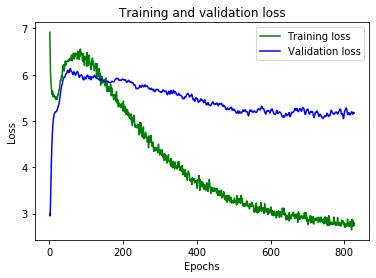

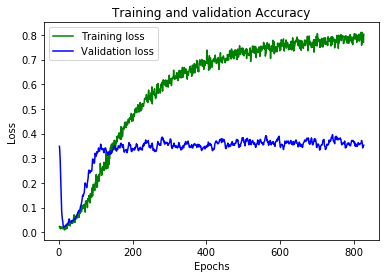

In [4]:
sv.visualize_training()

In [ ]:
# Test
sv.set_gpus("1")
sv.test_generator(sv.test_set)